# Setup

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [2]:
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as ani
import importlib
import os
from tqdm.notebook import tqdm
from collections import OrderedDict
import re
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import json
import sys
import imp

In [3]:
import plot_checkpoints

In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [5]:
import matplotlib as mpl
plt.style.use(['dark_background'])
mpl.rcParams['axes.facecolor'] = (27/256, 27/256, 27/256)
mpl.rcParams['figure.facecolor'] = (27/256, 27/256, 27/256)
mpl.rcParams['legend.facecolor'] = (50/256, 50/256, 50/256)
mpl.rcParams['savefig.facecolor'] = (27/256, 27/256, 27/256)
data_color = (0.2, 0.7, 1.0, 1.0)
samp_color = (1.0, 0.7, 0.1, 0.6)
aux_color =(0, 0.9, 0.0, 0.6)

colors = ['#ff005ca0', '#eb6a7d', '#cd98a1', '#9dbfc6', '#00ff80ff', '#00e2ed0b']
xrange = np.linspace(0, 1 / (25000 / 3 / 8) * 32 * 1000, 32)

# xrange = np.linspace(0, 1/(25000/3) * 255 * 1000, 256)
B_xrange = np.array([-300.      , -281.81583 , -263.63168 , -245.44751 , -227.26334 , -209.07918 , -190.89502 , -172.71085 , -154.52669 , -136.34251 , -118.158356,  -99.97419 ,  -81.79002 ,  -63.60586 ,  -45.421696, -27.237532,   -9.053368,    9.130797,   27.314962,   45.499126,  63.683292,   81.867455,  100.05162 ,  118.23579 ,  136.41995 , 154.60411 ,  172.78828 ,  190.97244 ,  209.1566  ,  227.34077 , 245.52493 ,  263.7091  ,  281.89328 ,  300.07742 ,  318.2616  , 336.44577 ,  354.6299  ,  372.8141  ,  390.99826 ,  409.1824  , 427.36658 ,  445.55075 ,  463.73492 ,  481.91907 ,  500.10324 , 518.2874  ,  536.47156 ,  554.65576 ,  572.8399  ,  591.02405 , 609.20825 ,  627.3924  ,  645.57654 ,  663.76074 ,  681.9449  , 700.129   ,  718.31323 ,  736.4974  ,  754.6815  ,  772.8657  , 791.04987 ,  809.234   ,  827.4182  ,  845.60236 ,  863.78656 , 881.9707  ,  900.15485 ,  918.33905 ,  936.5232  ,  954.70734 , 972.89154 ,  991.0757  , 1009.2598  , 1027.444   , 1045.6282  , 1063.8124  , 1081.9965  , 1100.1807  , 1118.3649  , 1136.549   , 1154.7332  , 1172.9174  , 1191.1014  , 1209.2856  , 1227.4698  , 1245.6539  , 1263.8381  , 1282.0223  , 1300.2064  , 1318.3906  , 1336.5748  , 1354.759   , 1372.9431  , 1391.1273  , 1409.3115  , 1427.4956  , 1445.6798  , 1463.864   , 1482.0481  , 1500.2323  , 1518.4165  , 1536.6006  , 1554.7848  , 1572.969   , 1591.1531  , 1609.3373  , 1627.5215  , 1645.7056  , 1663.8898  , 1682.074   , 1700.258   , 1718.4423  , 1736.6265  , 1754.8105  , 1772.9948  , 1791.179   , 1809.363   , 1827.5472  , 1845.7314  , 1863.9155  , 1882.0997  , 1900.2839  , 1918.468   , 1936.6522  , 1954.8364  , 1973.0205  , 1991.2047  , 2009.3889  ])

In [6]:
# mpl.rcdefaults()

In [7]:
device = torch.device('cuda:0')

In [8]:
torch.cuda.get_device_name(torch.device('cuda:0'))

'NVIDIA GeForce RTX 2070 SUPER'

In [9]:
# sys.path.remove('')

In [10]:
sys.path.remove('/home/phil/Desktop/EBMs/lapd-ebm') # Remove this script directory path

## define langevin func

In [11]:
def sample_langevin_cuda_tqdm(x, model, sample_steps=10, step_size=10, noise_scale=0.005, conditional_mask=None,
                              return_energies=False, return_all_steps=False):
    if return_energies:
        energies = []
        grad_mag = []
        noise_mag = []
    if return_all_steps:
        all_steps_samples = []
    if conditional_mask is None:
        conditional_mask = torch.ones((1, x.shape[1]), device=device)
    gradient_enabled_mask = torch.cat([torch.ones((1, x.shape[1] - 10)),
                                       torch.zeros((1, 10))], dim=1).to(x)
    for _ in tqdm(range(sample_steps)):
        # Noise / implementation in the style of Du 2019
        # noise = torch.randn_like(x) * noise_scale
        # model_output = model(x + noise)
        # Noise / implementation in the style of Nijkamp 2020
        noise = torch.randn_like(x) * step_size
        model_output = model(x)
        if return_energies:
            energies.append(model_output.to('cpu').detach().numpy())
        # Only inputs so that only grad wrt x is calculated (and not all remaining vars)
        # implementation in the style of Nijkamp 2020
        gradient = torch.autograd.grad(model_output.sum(), x, only_inputs=True)[0] * (step_size ** 2) / 2
        # implementation in the style of Du 2019
        # gradient = torch.autograd.grad(model_output.sum(), x, only_inputs=True)[0] * step_size
        if return_energies:
            grad_mag.append(gradient.to('cpu').detach().numpy())
            noise_mag.append(noise.to('cpu').detach().numpy())
        x = x - (gradient - noise) * gradient_enabled_mask * conditional_mask
        if return_all_steps:
            all_steps_samples.append(x)
    if return_all_steps:
        x = all_steps_samples
    if return_energies:
        return x, energies, grad_mag, noise_mag
    return x

In [12]:
data_all = np.load("data/data-MSI-mini_2022-9-28_sets-1-train.npz")['signals']
data_valid = np.load("data/data-MSI-mini_2022-9-28_sets-1-train.npz")['signals']

## Load model

In [140]:
# del ebm
# del ebm.ModularWithRNNBackbone
# model_path = "2022-10-06_15h-20m-51s"
# model_path = "2022-10-11_01h-41m-44s"
# model_path = "2022-10-13_17h-27m-21s"
# model_path = "2022-10-15_00h-30m-22s"
# model_path = "2022-10-16_00h-42m-28s"

# model_path = "2022-10-16_17h-18m-57s"
# model_version = "checkpoints/model-29-499"

# model_version = "checkpoints/model-6-451"
# model_version = "checkpoints/model-25-293"

# model_path = "2023-02-10_15h-12m-21s"
# model_version = "checkpoints/model-0-121"

# model_path = "2023-02-14_15h-14m-01s"
# model_version = "checkpoints/model-19-499"

model_path = "2022-10-12_14h_51m_30s"
# model_version = "checkpoints/model-7-246"
model_version = "checkpoints/model-25-3"

# sys.path.append("/home/phil/Desktop/EBMs/lapd-ebm/experiments_modular/" + model_path + "/")
# os.chdir("/home/phil/Desktop/EBMs/lapd-ebm/experiments_modular/" + model_path "/")

os.chdir("/home/phil/Desktop/EBMs/lapd-ebm/experiments_modular/2022-10-12_14h-51m-30s/")

print(sys.path)

spec = importlib.util.spec_from_file_location("modular_ebm_copy", "modular_ebm_copy.py")
# spec = importlib.util.spec_from_file_location("modular_ebm_copy", "experiments_modular/" + model_path + "/modular_ebm_copy.py")
ebm = importlib.util.module_from_spec(spec)
spec.loader.exec_module(ebm)
# sys.path.remove("/home/phil/Desktop/EBMs/lapd-ebm/experiments_modular/" + model_path + "/")
sample_langevin = ebm.sample_langevin
sample_langevin_cuda = ebm.sample_langevin_cuda
ReplayBuffer = ebm.ReplayBuffer
try:
    perturb_samples = ebm.perturb_samples
except:
    pass

# with open("experiments_modular/" + model_path + "/" + "hyperparams.json") as json_f:
with open("hyperparams.json") as json_f:
    hyperparams = json.loads(json_f.read())

# imp.reload(ebm)
model = ebm.ModularWithRNNBackbone(hyperparams).to(device)
# ckpt = torch.load("experiments_modular/" + model_path + "/" + model_version + ".pt")
ckpt = torch.load(model_version + ".pt")

model_dict = OrderedDict()
pattern = re.compile('module.')
state_dict = ckpt['model_state_dict']
for k,v in state_dict.items():
    if re.search("module", k):
        model_dict[re.sub(pattern, '', k)] = v
    else:
        model_dict = state_dict
model.load_state_dict(model_dict, strict=True)
# data = torch.tensor(np.load("data/isat_downsampled_8_div3.npz")['arr_0'].reshape(-1, 10)).float()

data_path = "/home/phil/Desktop/EBMs/lapd-ebm/data/" + hyperparams['dataset']
data = ebm.load_data(data_path)
# mean = np.load(data_path)['mean']
# ptp = np.load(data_path)['ptp']

# replay_buffer = ReplayBuffer(ckpt['replay_buffer_list'].shape[0], np.random.randn(*data.shape))
# replay_buffer.sample_list = ckpt['replay_buffer_list']
model(torch.zeros((2, 381)).cuda())
print("Number of parameters: {}".format(np.sum([p.numel() for p in model.parameters() if p.requires_grad])))

data_valid = ebm.load_data("/home/phil/Desktop/EBMs/lapd-ebm/data/" + hyperparams['dataset'])

['/home/phil/anaconda3/envs/python3.9/lib/python39.zip', '/home/phil/anaconda3/envs/python3.9/lib/python3.9', '/home/phil/anaconda3/envs/python3.9/lib/python3.9/lib-dynload', '', '/home/phil/anaconda3/envs/python3.9/lib/python3.9/site-packages', '/home/phil/anaconda3/envs/python3.9/lib/python3.9/site-packages/IPython/extensions', '/home/phil/.ipython']


/home/phil/anaconda3/envs/python3.9/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Number of parameters: 1857185


# Read from replay buffer

In [141]:
spec = importlib.util.spec_from_file_location("modular_ebm_copy", "modular_ebm_copy.py")
# spec = importlib.util.spec_from_file_location("modular_ebm_copy", "experiments_modular/" + model_path + "/modular_ebm_copy.py")
ebm = importlib.util.module_from_spec(spec)
spec.loader.exec_module(ebm)
ReplayBuffer = ebm.ReplayBuffer
# ckpt = torch.load("experiments_modular/" + model_path + "/" + model_version + ".pt")
ckpt = torch.load(model_version + ".pt")
replay_buffer = ReplayBuffer(ckpt['replay_buffer_list'].shape[0], np.random.randn(8192, 381))
replay_buffer.sample_list = ckpt['replay_buffer_list']

In [142]:
# data_filename = "data/data-MSI-all_2022-5-22_17-6-24"
# data_path = data_filename + "-valid.npz"
# data = ebm.load_data(data_path)
# mean = np.zeros((10))
ptp = np.load(data_path)['scale']

In [143]:
data_valid.shape

torch.Size([127898, 381])

In [144]:
replay_buffer.sample_list.shape

torch.Size([128, 381])

## Real data

In [19]:
np.mean(data_valid.cpu().numpy()[:, 20:25], axis=1).shape

(127898,)

In [20]:
I_7000 = data_valid.cpu()[np.where(np.mean(data_valid.cpu().numpy()[:, 20:25], axis=1) > 7200 / ptp['discharge_current'])[0]].numpy()

<IPython.core.display.Javascript object>


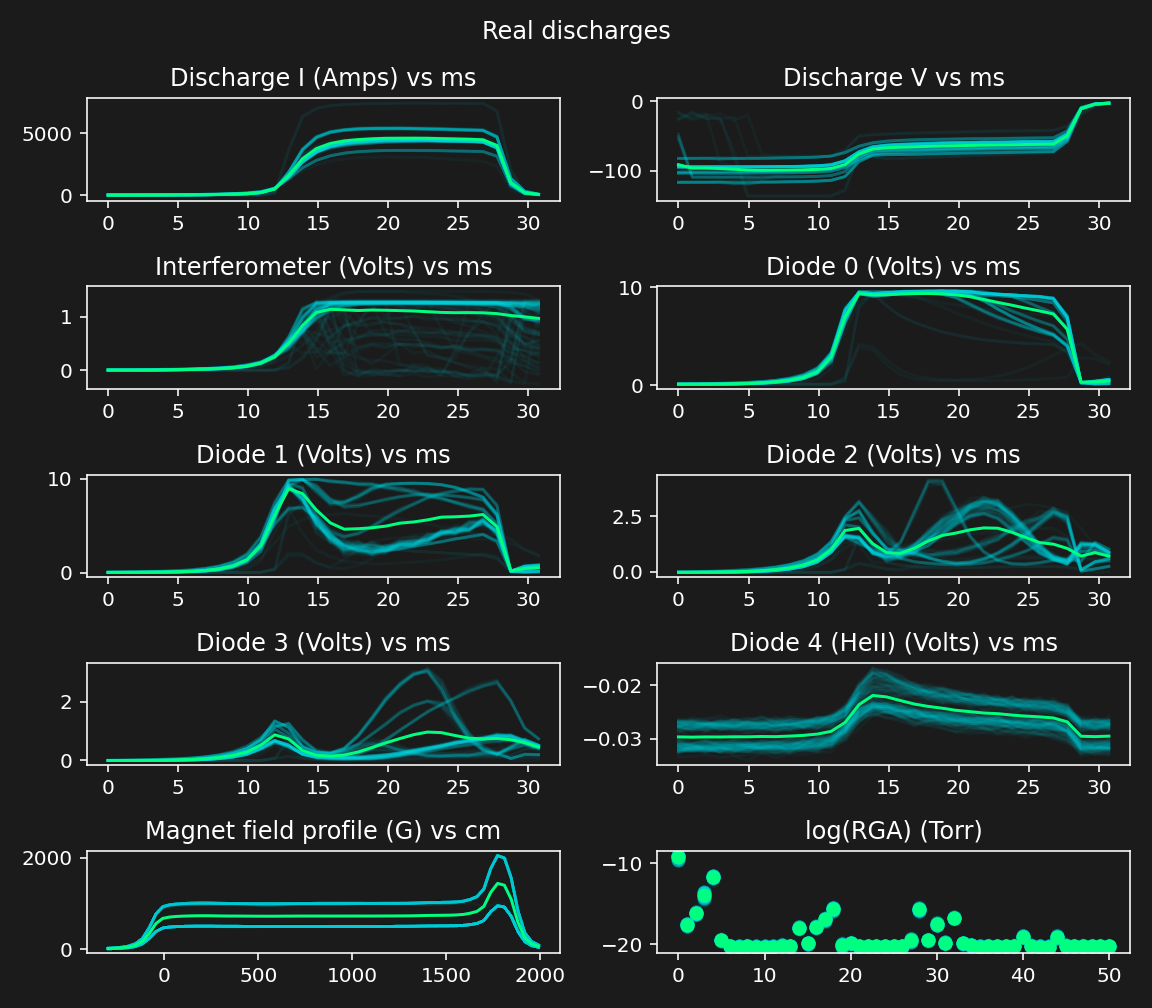

In [75]:
fig, axes = plt.subplots(5, 2, figsize=(8, 7), dpi=144)
plot_checkpoints.plot_all_msi(np.array(data_valid.cpu()[np.random.randint(0, 127898, 128)]), data_valid.cpu(), [], ptp, fig, axes)
# plot_checkpoints.plot_all_msi(I_7000, data_valid.cpu(), [], ptp, fig, axes)
fig.suptitle('Real discharges')
# plt.savefig('real_data.pdf')

## Replay buffer

<IPython.core.display.Javascript object>


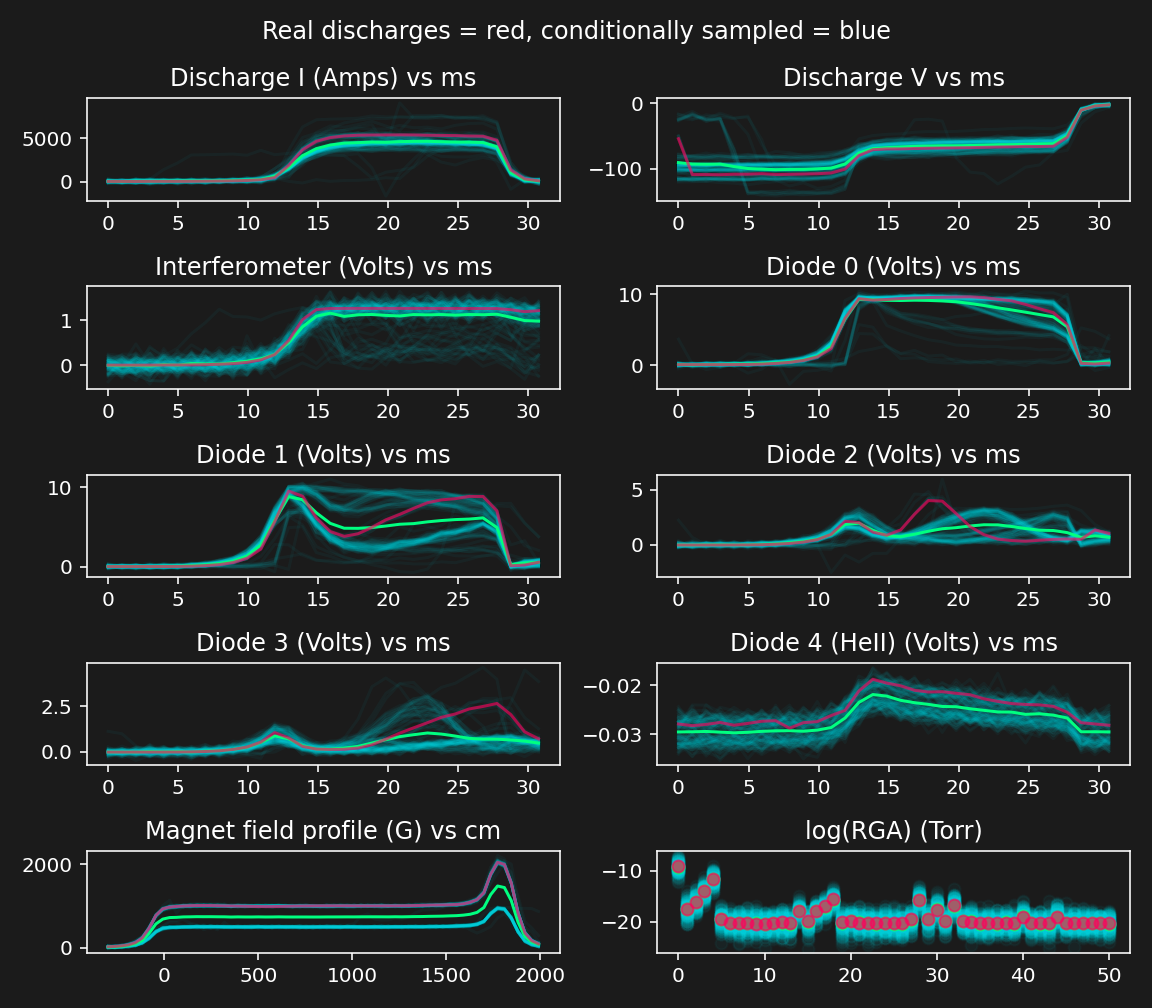

In [154]:
fig, axes = plt.subplots(5, 2, figsize=(8, 7), dpi=144)
plot_checkpoints.plot_all_msi(np.array(replay_buffer.sample_list.detach().cpu()), data_valid.cpu(), [0], ptp, fig, axes)

# Conditional sampling

## Via energy surface modification

In [179]:
class ConditionalFunc(torch.nn.Module):
    def __init__(self, energy_model):
        super(ConditionalFunc, self).__init__()
        
        self.energy_model = energy_model

    def forward(self, x): 
        E_modified = 2e4 * torch.pow(x[:, 15:25].mean(dim=1) - torch.tensor(7200 / ptp['discharge_current'], device=device,
                                                                            requires_grad=True), 2)
        E_modified = E_modified.unsqueeze(1)
        total_E = E_modified + self.energy_model(x)
#         return total_E
        return self.energy_model(x)
    
cond_func = ConditionalFunc(model)


dischargeI_mask = torch.cat([torch.ones((1, 15)), torch.zeros((1, 10)), torch.ones((1, 7))], dim=1)
# dischargeI_mask = torch.ones((1, 32))
# dischargeV_mask = torch.cat([torch.ones((1, 7)), torch.zeros((1, 4)), torch.ones((1, 21))], dim=1)
dischargeV_mask = torch.ones((1, 32))
interferometer_mask = torch.ones((1, 32))
diode0_mask = torch.ones((1, 32))
diode1_mask = torch.ones((1, 32))
diode2_mask = torch.ones((1, 32))
diode3_mask = torch.ones((1, 32))
diode4_mask = torch.ones((1, 32))
magnetic_mask = torch.zeros((1, 64))  # used to be zeros
gas_mask = torch.cat([torch.zeros((1, 2)), torch.zeros((1, 1)), torch.zeros((1, 48))], dim=1)
flags = torch.zeros((1, 10))
conditional_mask = torch.cat([dischargeI_mask, dischargeV_mask, interferometer_mask, 
                              diode0_mask, diode1_mask, diode2_mask, diode3_mask, diode4_mask, magnetic_mask, gas_mask, flags], dim=1).to(device)

conditional_mask = torch.ones((1, 381)).to(device)

# single diagnostic
dischargeI_mask = torch.zeros((1, 32))
dischargeV_mask = torch.zeros((1, 32))
interferometer_mask = torch.zeros((1, 32))
diode0_mask = torch.ones((1, 32))
diode1_mask = torch.ones((1, 32))
diode2_mask = torch.ones((1, 32))
diode3_mask = torch.zeros((1, 32))
diode4_mask = torch.zeros((1, 32))
magnetic_mask = torch.zeros((1, 64))
gas_mask = torch.zeros((1, 51))
flags = torch.zeros((1, 10))
conditional_mask = torch.cat([dischargeI_mask, dischargeV_mask, interferometer_mask, 
                              diode0_mask, diode1_mask, diode2_mask, diode3_mask, diode4_mask, magnetic_mask, gas_mask, flags], dim=1).to(device)

In [180]:
n_samp_total = 128
n_samp_divis = 1
n_samp = n_samp_total // n_samp_divis

steps = hyperparams['sample_steps'] * 6
step_size = hyperparams['step_size']
noise = hyperparams['noise_scale'] * 0

samp_begin = 0
samp_end = 371

data_init_idx = 9928
init_data = data_valid[data_init_idx].clone().detach().repeat((n_samp, 1)).to(device) * (1-conditional_mask)
init_data[:, samp_begin:samp_end] += conditional_mask[:, samp_begin:samp_end] * (torch.rand((n_samp, samp_end - samp_begin), requires_grad=True).to(device) * 2 - 1)

# init_data[:, 15:25] = 7200/1e4

data_samps = []
samp_energies = []
samp_grad = []
samp_noise = []

# for i in range(n_samp_divis):
#     temp_samps, temp_energies, temp_samp_grad, temp_samp_noise = sample_langevin_cuda_tqdm(init_data, model, steps, step_size, noise,
#                                                             conditional_mask, return_energies=True)
temp_samps, temp_energies, temp_samp_grad, temp_samp_noise = sample_langevin_cuda_tqdm(init_data, cond_func, steps, step_size, noise,
                                                        conditional_mask, return_energies=True, return_all_steps=True)
temp_samps = [samp.to('cpu').detach().numpy() for samp in temp_samps]
# data_samps.append(temp_samps)
data_samps = np.array(temp_samps)

samp_energies.append(temp_energies)
samp_grad.append(temp_samp_grad)
samp_noise.append(temp_samp_noise)
    
# data_samps = np.concatenate(data_samps, 0)
samp_energies = np.concatenate(samp_energies, 1)
samp_grad = np.concatenate(samp_grad, 1)
samp_noise = np.concatenate(samp_noise, 1)

  0%|          | 0/300 [00:00<?, ?it/s]

### All diagnostic plots

<IPython.core.display.Javascript object>


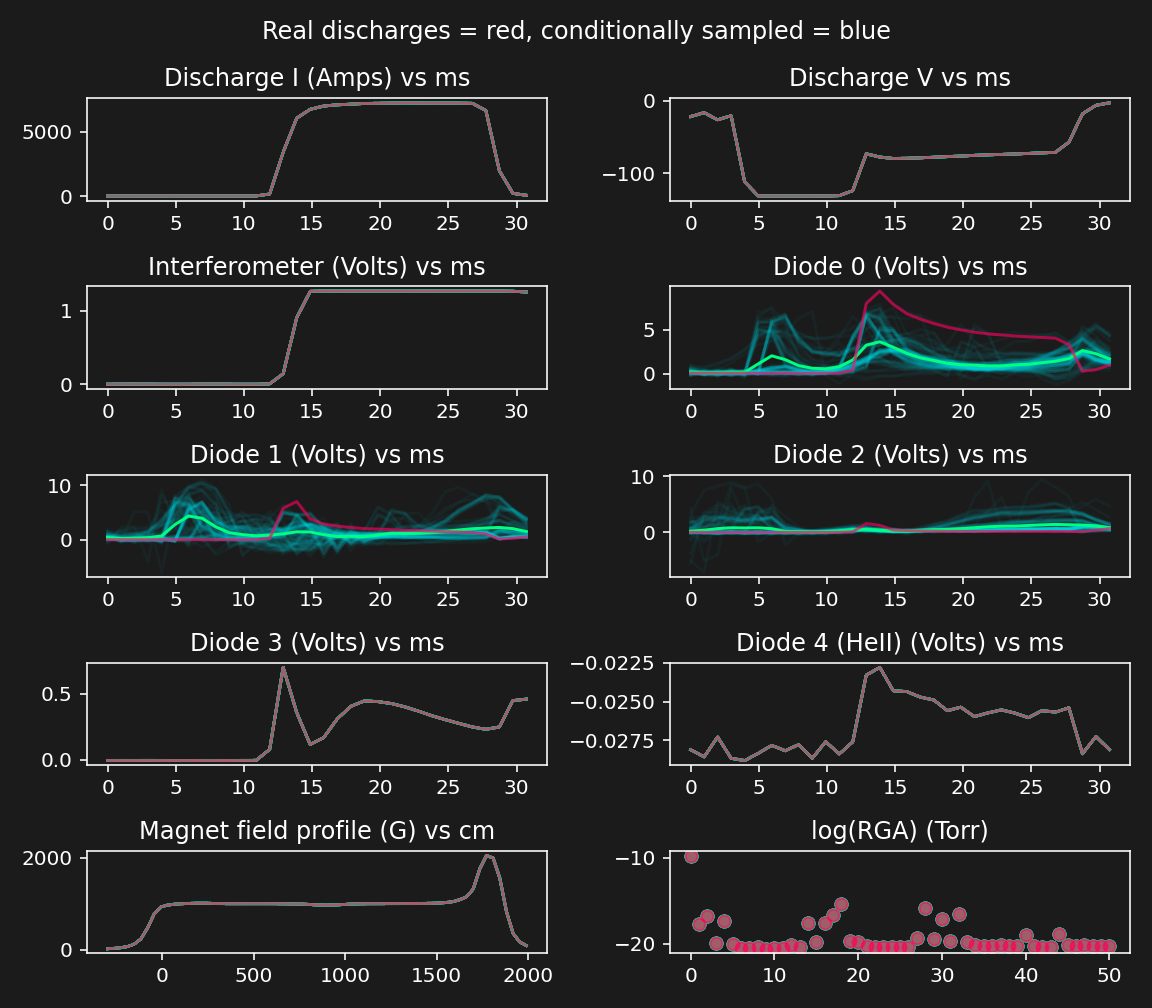

In [181]:
fig, axes = plt.subplots(5, 2, figsize=(8, 7), dpi=144)
plot_checkpoints.plot_all_msi(data_samps[-1][0:128], data_valid.cpu(), [9928], ptp, fig, axes) 
# plt.savefig('7200A_energy_constrained_samples.pdf')
# plt.savefig('unconditional_samples.pdf')

### MCMC energies

<IPython.core.display.Javascript object>


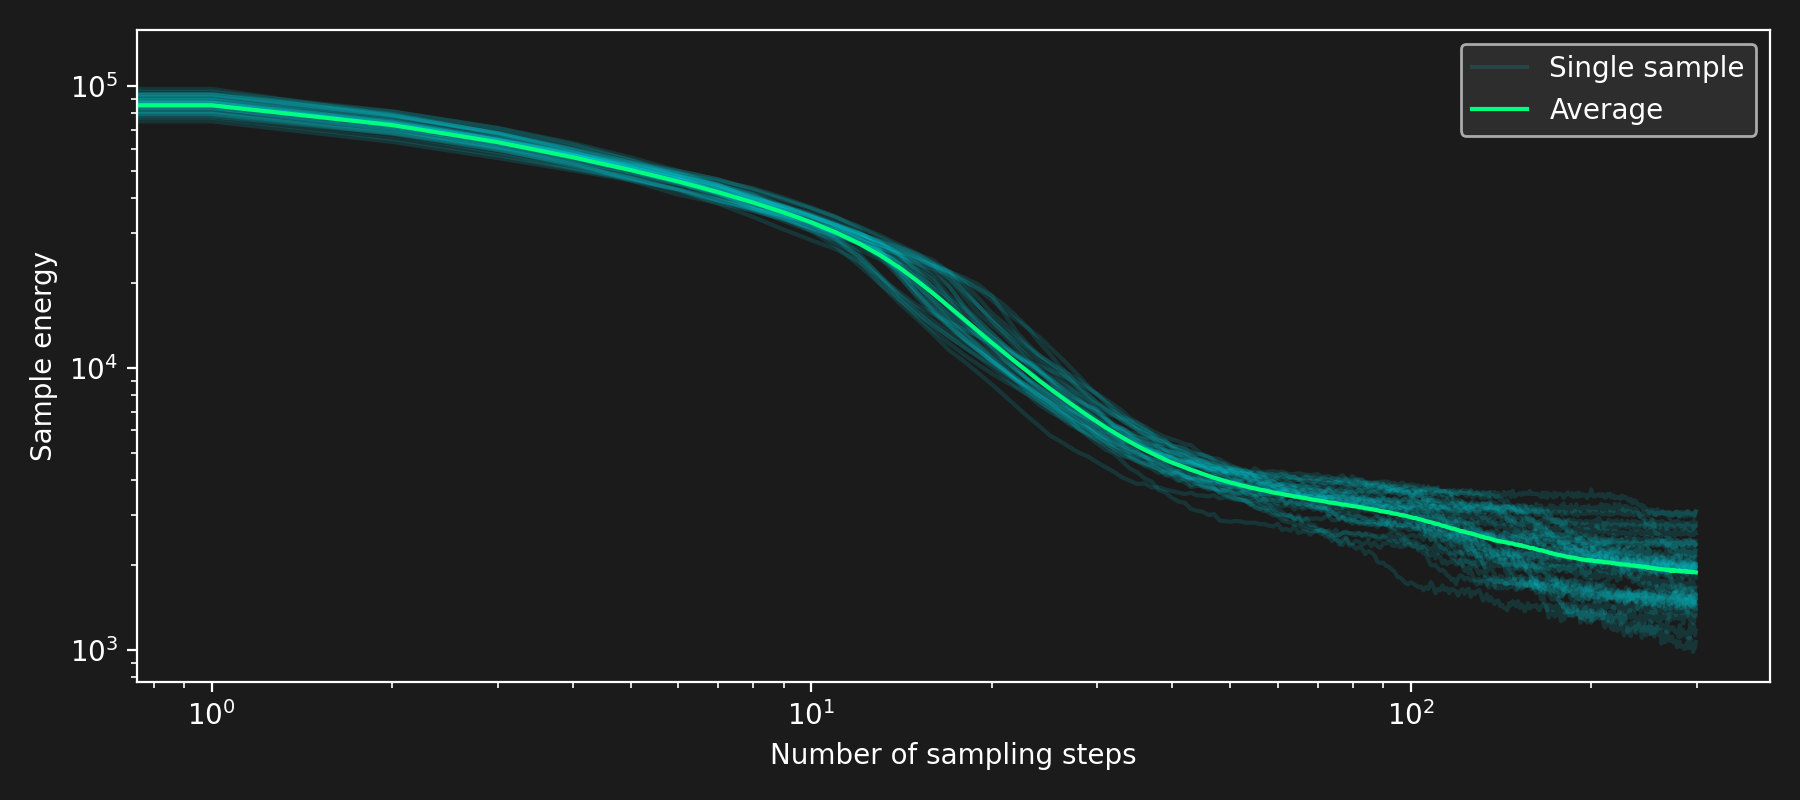

In [126]:
y_offset = np.min(samp_energies[:, -1]) - 1000

plt.figure(figsize=(9, 4), dpi=200)
for i in range(32):
    plt.plot(samp_energies[:, i] - y_offset, color='#00e2ed22', label="Single sample" if i == 0 else None)
# plt.plot(samp_energies[:, 1])
# plt.plot(samp_energies[:, 2])
# plt.plot(samp_energies[:, 3])
plt.plot(np.mean(samp_energies, axis=1) - y_offset, color=colors[4], label="Average")
plt.legend()
plt.ylabel('Sample energy')
plt.xlabel('Number of sampling steps')
plt.yscale('log')
plt.xscale('log')
plt.tight_layout()
# plt.savefig("7200A_MCMC_energies.pdf")

### Integrating MCMC curves

In [64]:
cum_grad_mag[0, 16]

1.6972018

<IPython.core.display.Javascript object>


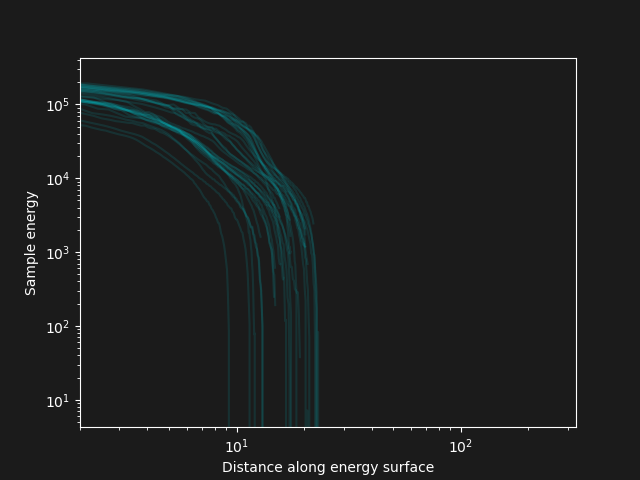

Text(0, 0.5, 'Sample energy')

In [49]:
cum_grad_mag = np.cumsum(np.sqrt(np.sum(samp_grad[:, :] ** 2, axis=1)), axis=0)
plt.figure()
for i in range(32):
    plt.plot(np.concatenate([np.zeros(1), cum_grad_mag[0:-1, i]]), samp_energies[0:, i], color='#00e2ed1d')
plt.xscale('log')
plt.yscale('log')
plt.xlim(2, 327)
plt.xlabel('Distance along energy surface')
plt.ylabel('Sample energy')

### Plotting single diagnostic

In [50]:
colors = ['#ff005ca0', '#eb6a7d', '#cd98a1', '#9dbfc6', '#00ff80ff', '#00e2ed0b']
xrange = np.linspace(0, 1 / (25000 / 3 / 8) * 32 * 1000, 32)

In [51]:
data_samps.shape

(100, 128, 381)

<IPython.core.display.Javascript object>


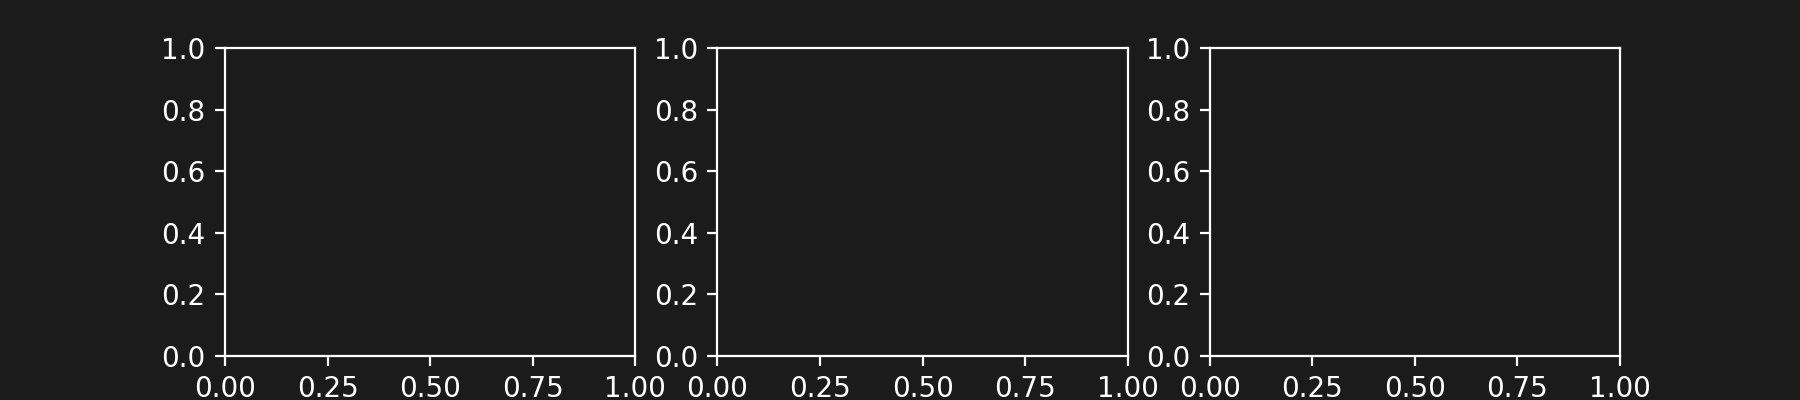

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│ /tmp/ipykernel_2766285/256966124.py:4 in <module>                                         │
│                                                                                           │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_2766285/256966124.py'                │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [153]:
fig, axes = plt.subplots(1, 3, figsize=(9, 2), dpi=200, sharey=False)
data_samps_mean = np.mean(np.array(data_samps), axis=1)
for i in range(32):
    axes[0].plot(xrange[0:32], data_samps[0][i][0:32] * ptp['discharge_current']/1e3, color='#00e2ed1d', label="Sampled" if i == 0 else None)
    axes[1].plot(xrange[0:32], data_samps[10][i][0:32] * ptp['discharge_current']/1e3, color='#00e2ed1d', label="Sampled" if i == 0 else None)
    axes[2].plot(xrange[0:32], data_samps[99][i][0:32] * ptp['discharge_current']/1e3, color='#00e2ed1d', label="Sampled" if i == 0 else None)
axes[0].plot(xrange[0:32], data_samps_mean[0, 0:32] * ptp['discharge_current']/1e3, color=colors[4], label="Sampled mean")
axes[1].plot(xrange[0:32], data_samps_mean[10, 0:32] * ptp['discharge_current']/1e3, color=colors[4], label="Sampled mean")
axes[2].plot(xrange[0:32], data_samps_mean[99, 0:32] * ptp['discharge_current']/1e3, color=colors[4], label="Sampled mean")
# fig.suptitle('Sampled discharge current (kA) vs time (ms)')
axes[1].set_title('Sampled discharge current (kA) vs time (ms)')
plt.tight_layout()
# plt.savefig("dpp2022_poster/sample_examples.pdf")

## Via hard constraint

In [20]:
class ConditionalFunc(torch.nn.Module):
    def __init__(self, energy_model):
        super(ConditionalFunc, self).__init__()
        
        self.energy_model = energy_model

    def forward(self, x): 
#         E_modified = 2e4 * torch.pow(x[:, 15:25].mean(dim=1) - torch.tensor(7200 / ptp['discharge_current'], device=device,
#                                                                             requires_grad=True), 2)
#         E_modified = E_modified.unsqueeze(1)
#         total_E = E_modified + self.energy_model(x)
#         return total_E

        return self.energy_model(x)
    
cond_func = ConditionalFunc(model)

dischargeI_mask = torch.cat([torch.ones((1, 15)), torch.zeros((1, 10)), torch.ones((1, 7))], dim=1)
# dischargeI_mask = torch.ones((1, 32))
# dischargeV_mask = torch.cat([torch.ones((1, 7)), torch.zeros((1, 4)), torch.ones((1, 21))], dim=1)
dischargeV_mask = torch.ones((1, 32))
interferometer_mask = torch.ones((1, 32))
diode0_mask = torch.ones((1, 32))
diode1_mask = torch.ones((1, 32))
diode2_mask = torch.ones((1, 32))
diode3_mask = torch.ones((1, 32))
diode4_mask = torch.ones((1, 32))
magnetic_mask = torch.zeros((1, 64))  # used to be zeros
gas_mask = torch.cat([torch.zeros((1, 2)), torch.zeros((1, 1)), torch.zeros((1, 48))], dim=1)
flags = torch.ones((1, 10))
conditional_mask = torch.cat([dischargeI_mask, dischargeV_mask, interferometer_mask, 
                              diode0_mask, diode1_mask, diode2_mask, diode3_mask, diode4_mask, magnetic_mask, gas_mask, flags], dim=1).to(device)

In [21]:
n_samp_total = 128
n_samp_divis = 1
n_samp = n_samp_total // n_samp_divis

steps = hyperparams['sample_steps'] * 2
step_size = hyperparams['step_size']
noise = hyperparams['noise_scale']

samp_begin = 0
samp_end = 371

data_init_idx = 9928
init_data = data_valid[data_init_idx].clone().detach().repeat((n_samp, 1)).to(device) * (1-conditional_mask)
init_data[:, samp_begin:samp_end] += conditional_mask[:, samp_begin:samp_end] * (torch.rand((n_samp, samp_end - samp_begin), requires_grad=True).to(device) * 2 - 1)

init_data[:, 15:25] = 7200/1e4

data_samps = []
samp_energies = []
samp_grad = []
samp_noise = []

for i in range(n_samp_divis):
#     temp_samps, temp_energies, temp_samp_grad, temp_samp_noise = sample_langevin_cuda_tqdm(init_data, model, steps, step_size, noise,
#                                                             conditional_mask, return_energies=True)
    temp_samps, temp_energies, temp_samp_grad, temp_samp_noise = sample_langevin_cuda_tqdm(init_data, cond_func, steps, step_size, noise,
                                                            conditional_mask, return_energies=True)
    temp_samps = temp_samps.to('cpu').detach().numpy()
    data_samps.append(temp_samps)
    samp_energies.append(temp_energies)
    samp_grad.append(temp_samp_grad)
    samp_noise.append(temp_samp_noise)
    
data_samps = np.concatenate(data_samps, 0)
samp_energies = np.concatenate(samp_energies, 1)
samp_grad = np.concatenate(samp_grad, 1)
samp_noise = np.concatenate(samp_noise, 1)

  0%|          | 0/300 [00:00<?, ?it/s]

### All diagnostic plots

In [22]:
fig, axes = plt.subplots(5, 2, figsize=(8, 7), dpi=144)
plot_checkpoints.plot_all_msi(data_samps[:], data_valid.cpu(), [9928], ptp, fig, axes) 

<IPython.core.display.Javascript object>

### MCMC energies

<IPython.core.display.Javascript object>


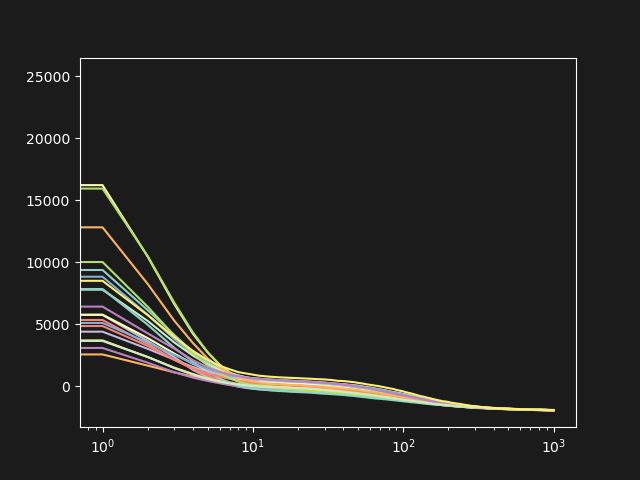

In [48]:
plt.figure()
for i in range(20):
    plt.plot(samp_energies[:, i])
# plt.plot(samp_energies[:, 1])
# plt.plot(samp_energies[:, 2])
# plt.plot(samp_energies[:, 3])
# plt.yscale('log')
plt.xscale('log')

## Plot based on energy levels

<IPython.core.display.Javascript object>


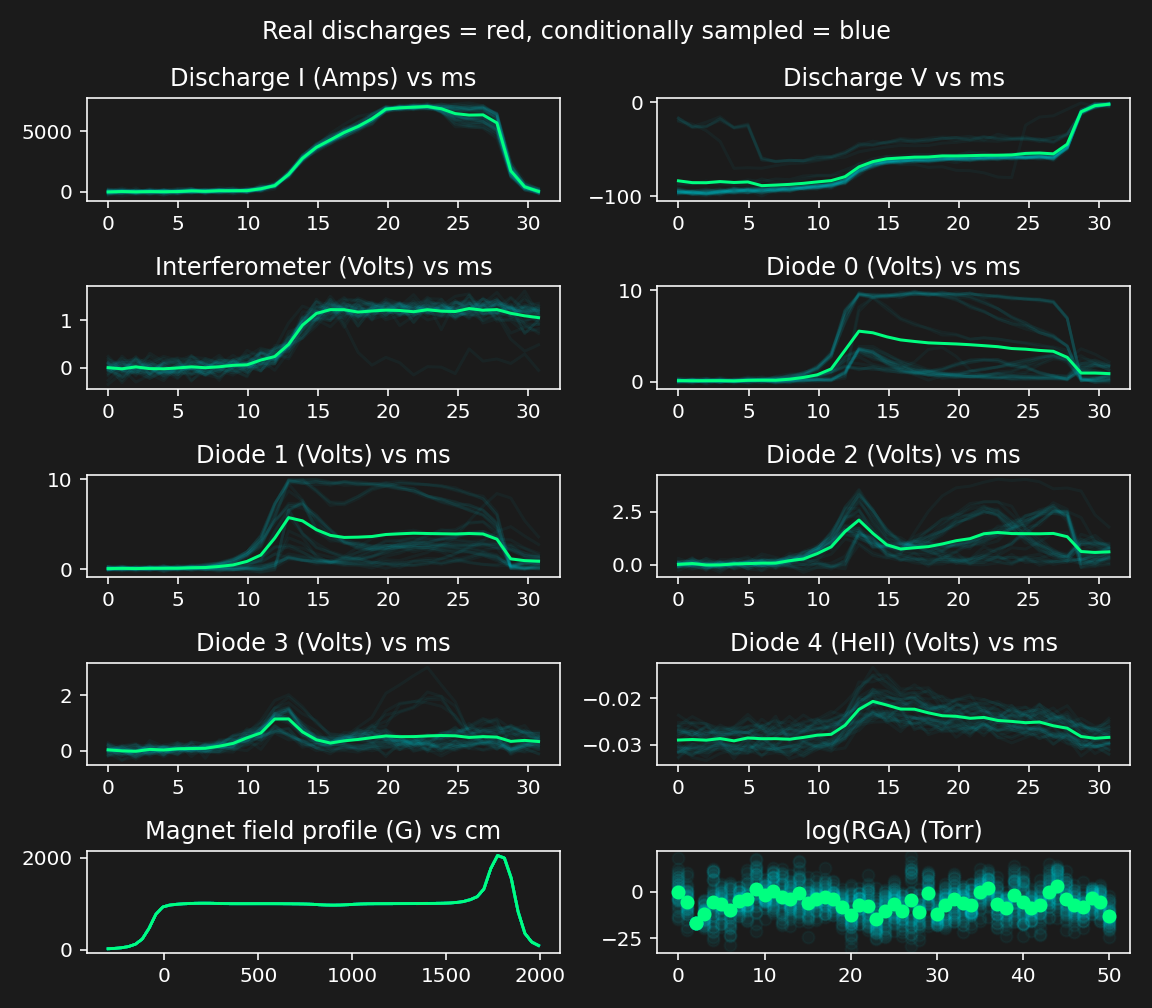

In [248]:
samples_to_plot = np.where(samp_energies[-1, :] > 20000)[0]
fig, axes = plt.subplots(5, 2, figsize=(8, 7), dpi=144)
plot_checkpoints.plot_all_msi(data_samps[samples_to_plot], data_valid.cpu(), [], ptp, fig, axes) 

<IPython.core.display.Javascript object>


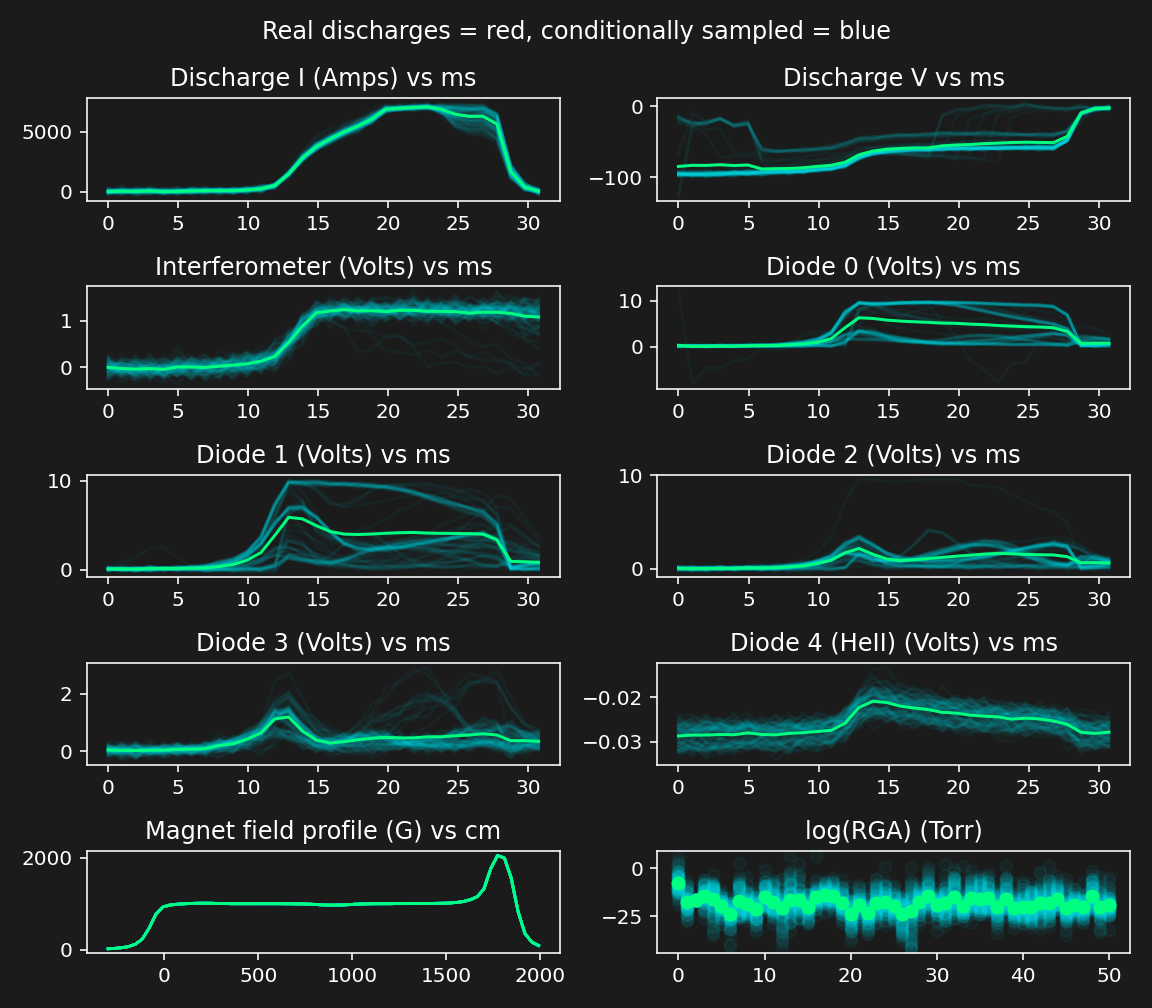

In [249]:
samples_to_plot = np.where(samp_energies[-1, :] < 20000)[0]
fig, axes = plt.subplots(5, 2, figsize=(8, 7), dpi=144)
plot_checkpoints.plot_all_msi(data_samps[samples_to_plot], data_valid.cpu(), [], ptp, fig, axes) 

# Trend inference

## Via hard constraint

In [145]:
class ConditionalFunc(torch.nn.Module):
    def __init__(self, energy_model):
        super(ConditionalFunc, self).__init__()
        
        self.energy_model = energy_model

    def forward(self, x): 

        return self.energy_model(x)
    

cond_func = ConditionalFunc(model)

dischargeI_mask = torch.cat([torch.ones((1, 15)), torch.zeros((1, 10)), torch.ones((1, 7))], dim=1)
# dischargeI_mask = torch.ones((1, 32))
# dischargeV_mask = torch.cat([torch.ones((1, 7)), torch.zeros((1, 4)), torch.ones((1, 21))], dim=1)
dischargeV_mask = torch.ones((1, 32))
interferometer_mask = torch.ones((1, 32))
diode0_mask = torch.ones((1, 32))
diode1_mask = torch.ones((1, 32))
diode2_mask = torch.ones((1, 32))
diode3_mask = torch.ones((1, 32))
diode4_mask = torch.ones((1, 32))
magnetic_mask = torch.zeros((1, 64))  # used to be zeros
gas_mask = torch.cat([torch.zeros((1, 2)), torch.zeros((1, 1)), torch.zeros((1, 48))], dim=1)
flags = torch.zeros((1, 10))
conditional_mask = torch.cat([dischargeI_mask, dischargeV_mask, interferometer_mask, 
                              diode0_mask, diode1_mask, diode2_mask, diode3_mask, diode4_mask, magnetic_mask, gas_mask, flags], dim=1).to(device)

In [146]:
num_constraints = 11
current_constraints = np.linspace(3000, 7000, num_constraints)

In [147]:
n_samp_total = 110
n_samp_divis = 1
n_samp = n_samp_total // n_samp_divis

steps = hyperparams['sample_steps'] * 3
step_size = hyperparams['step_size']
noise = hyperparams['noise_scale']

samp_begin = 0
samp_end = 371

data_init_idx = 9928
init_data = data_valid[data_init_idx].clone().detach().repeat((n_samp, 1)).to(device) * (1-conditional_mask)
# init_data = data_valid[np.random.randint(0, 127898, n_samp_total)].clone().detach().to(device) #* (1-conditional_mask)
init_data[:, samp_begin:samp_end] += conditional_mask[:, samp_begin:samp_end] * (torch.rand((n_samp, samp_end - samp_begin), requires_grad=True).to(device) * 2 - 1)
# init_data.requires_grad = True
# init_data.to(device)

# 3.5 - 7.2 kA

num_constraints = 11
current_constraints = np.linspace(3000, 7000, num_constraints)
samps_per_constraint = n_samp_total // num_constraints

for i in range(num_constraints):
    init_data[i * samps_per_constraint:(i + 1) * samps_per_constraint, 15:25] = current_constraints[i]/1e4

# init_data.requires_grad=True

    
data_samps = []
samp_energies = []
samp_grad = []
samp_noise = []

for i in range(n_samp_divis):
#     temp_samps, temp_energies, temp_samp_grad, temp_samp_noise = sample_langevin_cuda_tqdm(init_data, model, steps, step_size, noise,
#                                                             conditional_mask, return_energies=True)
    temp_samps, temp_energies, temp_samp_grad, temp_samp_noise = sample_langevin_cuda_tqdm(init_data, cond_func, steps, step_size, noise,
                                                            conditional_mask, return_energies=True)
    temp_samps = temp_samps.to('cpu').detach().numpy()
    data_samps.append(temp_samps)
    samp_energies.append(temp_energies)
    samp_grad.append(temp_samp_grad)
    samp_noise.append(temp_samp_noise)
    
data_samps = np.concatenate(data_samps, 0)
samp_energies = np.concatenate(samp_energies, 1)
samp_grad = np.concatenate(samp_grad, 1)
samp_noise = np.concatenate(samp_noise, 1)

  0%|          | 0/150 [00:00<?, ?it/s]

### Real plotted with sampled data

<IPython.core.display.Javascript object>


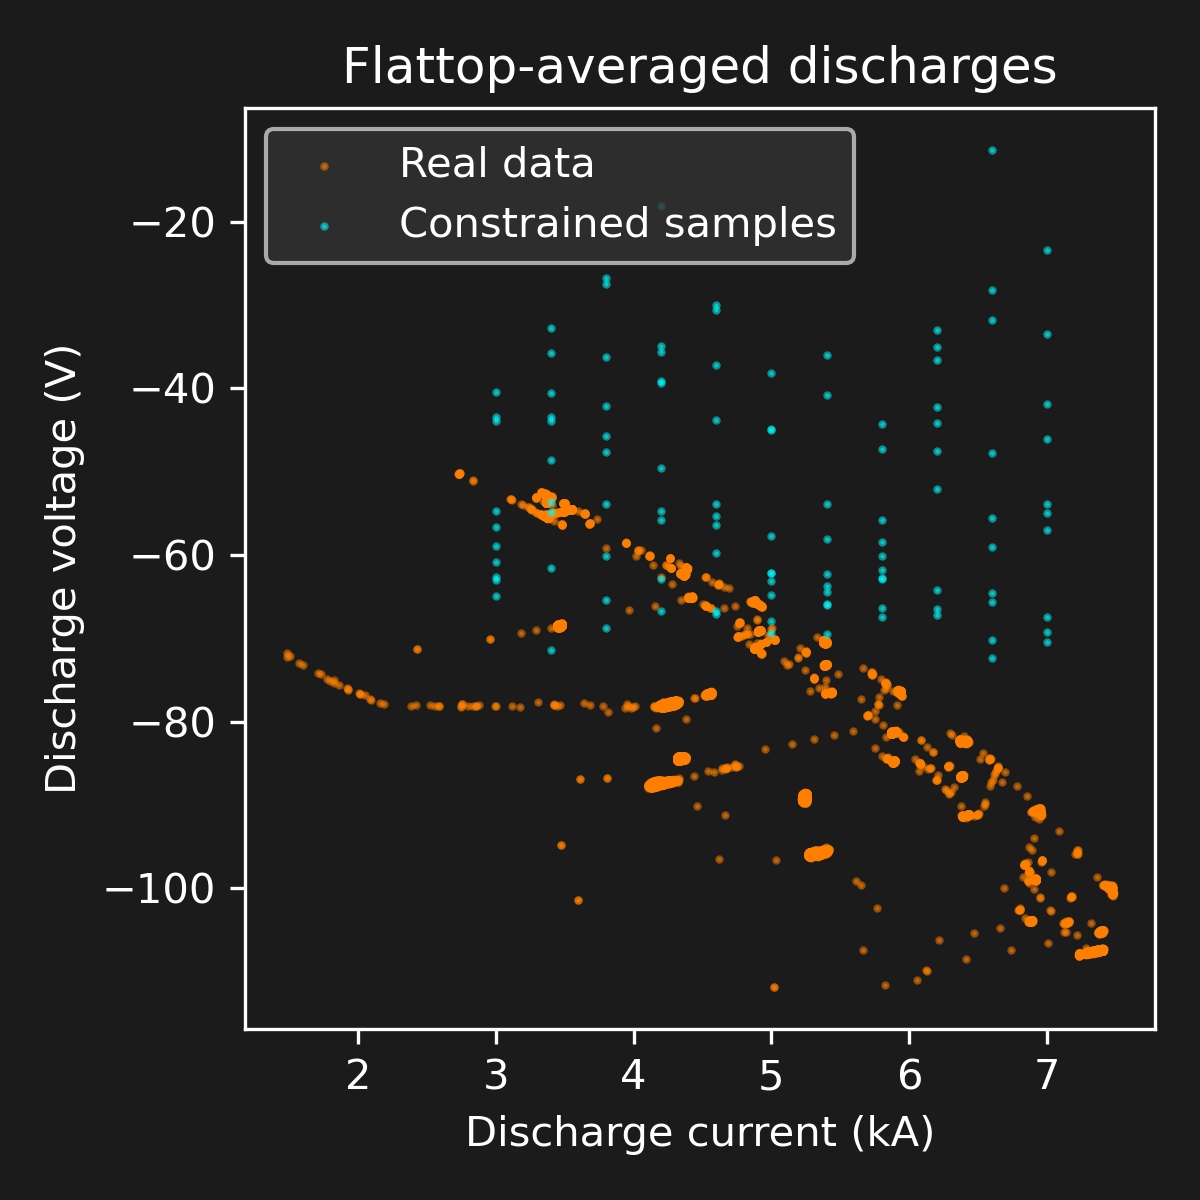

In [148]:
# fig, axes = plt.subplots(5, 2, figsize=(8, 7), dpi=144)
data_valid_np = np.array(data_valid.cpu())
plt.figure(figsize=(4, 4), dpi=300)
plt.title('Flattop-averaged discharges')
plt.scatter(np.mean(data_valid_np[:, 15:25], axis=1) * 1e1, np.mean(data_valid_np[:, 32+6:32+20] * 1e2, axis=1), s=1.0,
            label="Real data", color=[1.0, 0.5, 0.0, 0.5])
plt.scatter(np.mean(data_samps[:, 15:25], axis=(1)) * 1e1, np.mean(data_samps[:, 32+6:32+20], axis=1) * 1e2, s=1.0,
            label="Constrained samples", color=[0.0, 1.0, 1.0, 0.5])
plt.xlabel('Discharge current (kA)')
plt.ylabel('Discharge voltage (V)')
plt.legend()
plt.tight_layout()

# plot_checkpoints.plot_all_msi(np.array(data_valid.cpu()[np.random.randint(0, 127898, 128)]), data_valid.cpu(), [], ptp, fig, axes)
# # plot_checkpoints.plot_all_msi(I_7000, data_valid.cpu(), [], ptp, fig, axes)
# fig.suptitle('Real discharges')
# plt.savefig("real_vs_sampled_trends.pdf")

In [49]:
fig, axes = plt.subplots(5, 2, figsize=(8, 7), dpi=144)
plot_checkpoints.plot_all_msi(data_samps[:], data_valid.cpu(), [9928], ptp, fig, axes) 

<IPython.core.display.Javascript object>

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│ /tmp/ipykernel_2732030/3393257387.py:2 in <module>                                        │
│                                                                                           │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_2732030/3393257387.py'               │
│                                                                                           │
│ /home/phil/Desktop/EBMs/lapd-ebm/plot_checkpoints.py:142 in plot_all_msi                  │
│                                                                                           │
│   139 │   │   axes[0, 1].plot(xrange, data_samps[i, 32 * 1:32 * 2] * ptp['discharge_volta │
│   140 │   │   axes[1, 0].plot(xrange, data_samps[i, 32 * 2:32 * 3] * ptp['interferometer' │
│   141 │   │   axes[1, 1].plot(xrange, data_samps[i, 32 * 3:32 * 4] * ptp['diode_0'], colo │
│ ❱ 142 │   │   axes[2, 0].plot(xrange, data_samps[i, 32 * 4:32 * 5] * ptp['diode_1'], colo │
│   143 │   │   axes[2, 1].plot(xrange, data_samps[i, 32 * 5:32 * 6] * ptp['diode_2'], colo │
│   144 │   │   axes[3, 0].plot(xrange, data_samps[i, 32 * 6:32 * 7] * ptp['diode_3'], colo │
│   145 │   │   axes[3, 1].plot(xrange, data_samps[i, 32 * 7:32 * 8] * ptp['diode_4'], colo │
│                                                                                           │
│ /home/phil/anaconda3/envs/python3.9/lib/python3.9/site-packages/matplotlib/axes/_axes.py: │
│ 1605 in plot                                                                              │
│                                                                                           │
│   1602 │   │   (``'green'``) or hex strings (``'#008000'``).                              │
│   1603 │   │   """                                                                        │
│   1604 │   │   kwargs = cbook.normalize_kwargs(kwargs, mlines.Line2D)                     │
│ ❱ 1605 │   │   lines = [*self._get_lines(*args, data=data, **kwargs)]                     │
│   1606 │   │   for line in lines:                                                         │
│   1607 │   │   │   self.add_line(line)                                                    │
│   1608 │   │   self._request_autoscale_view(scalex=scalex, scaley=scaley)                 │
│                                                                                           │
│ /home/phil/anaconda3/envs/python3.9/lib/python3.9/site-packages/matplotlib/axes/_base.py: │
│ 315 in __call__                                                                           │
│                                                                                           │
│    312 │   │   │   if args and isinstance(args[0], str):                                  │
│    313 │   │   │   │   this += args[0],                                                   │
│    314 │   │   │   │   args = args[1:]                                                    │
│ ❱  315 │   │   │   yield from self._plot_args(this, kwargs)                               │
│    316 │                                                                                  │
│    317 │   def get_next_color(self):                                                      │
│    318 │   │   """Return the next color in the cycle."""                                  │
│                                                                                           │
│ /home/phil/anaconda3/envs/python3.9/lib/python3.9/site-packages/matplotlib/axes/_base.py: │
│ 501 in _plot_args                                                                         │
│                                                                                           │
│    498 │   │   │   self.axes.yaxis.update_units(y)                                        │
│    499 │   │                                                                              │
│    500 │   │   if x.shape[0] != y.shape[0]:       

### MCMC plot

<IPython.core.display.Javascript object>


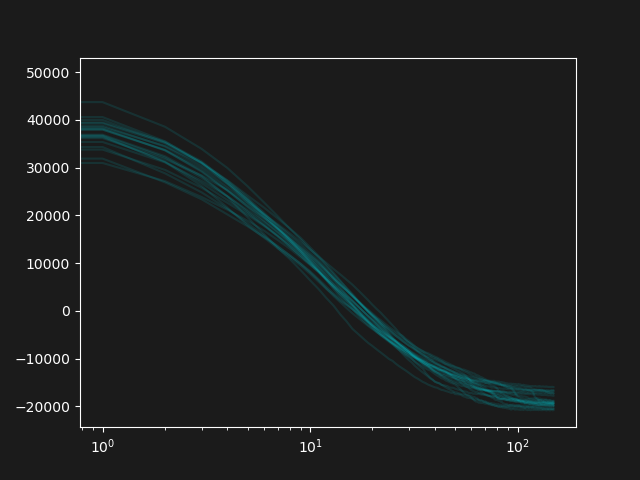

In [149]:
plt.figure()
for i in range(20):
    plt.plot(samp_energies[:, i], color='#00e2ed1d')
# plt.yscale('log')
plt.xscale('log')

<IPython.core.display.Javascript object>


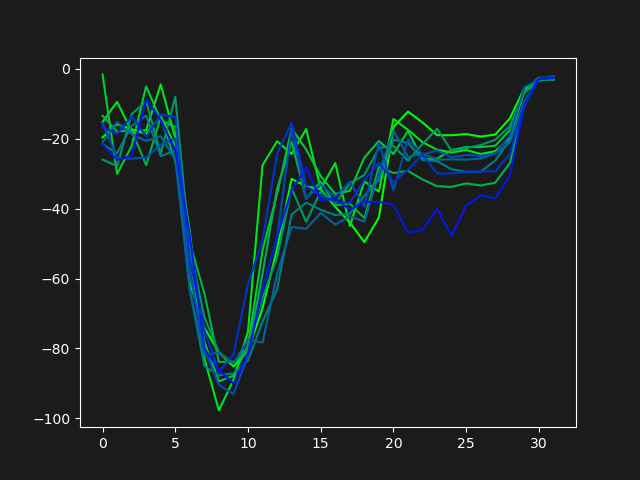

In [151]:
plt.figure()
for i in range(samps_per_constraint):
    plt.plot(np.mean(data_samps[i * num_constraints:(i + 1) * num_constraints, 32:64] * 100, axis=0),
             color=[0, 1-i/samps_per_constraint, 1*i/samps_per_constraint, 1])

<IPython.core.display.Javascript object>


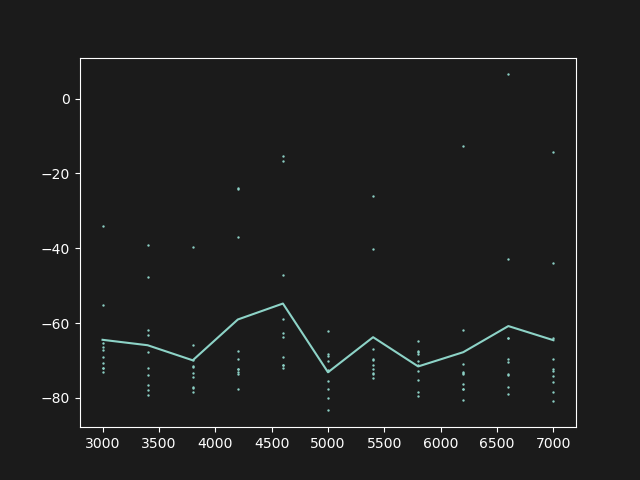

In [150]:
plt.figure()
plt.plot(np.mean(data_samps[:, 15:25].reshape(num_constraints, samps_per_constraint, 10) * 1e4, axis=(1,2)),
         np.mean(np.mean(data_samps[:, 32+5:32+10], axis=1).reshape(num_constraints, samps_per_constraint) * 100, axis=(1)))
plt.scatter(np.mean(data_samps[:, 15:25], axis=(1)) * 1e4, np.mean(data_samps[:, 32+5:32+10], axis=1) * 100, s=0.5)

# Movie of sample evolution

In [55]:
data_samps.shape

(100, 128, 381)

<IPython.core.display.Javascript object>


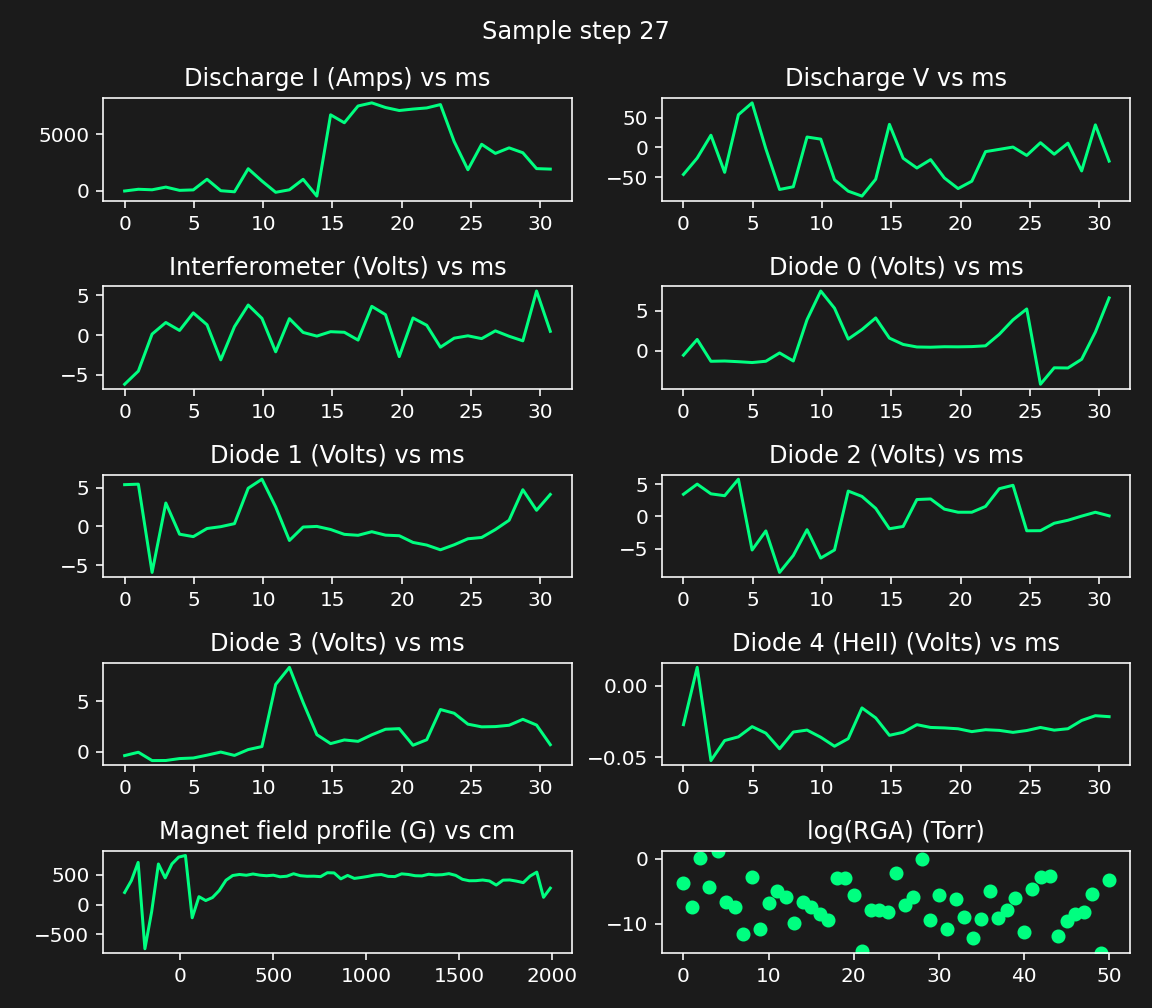

In [59]:
which_samp = 2

fig_mov, axes_mov = plt.subplots(5, 2, figsize=(8, 7), dpi=144)

axes_mov[0, 0].plot(xrange, data_samps[0, which_samp, 32 * 0:32 * 1] * ptp['discharge_current'], color=colors[4], label="Sampled")
axes_mov[0, 1].plot(xrange, data_samps[0, which_samp, 32 * 1:32 * 2] * ptp['discharge_voltage'], color=colors[4])
axes_mov[1, 0].plot(xrange, data_samps[0, which_samp, 32 * 2:32 * 3] * ptp['interferometer'], color=colors[4])
axes_mov[1, 1].plot(xrange, data_samps[0, which_samp, 32 * 3:32 * 4] * ptp['diode_0'], color=colors[4])
axes_mov[2, 0].plot(xrange, data_samps[0, which_samp, 32 * 4:32 * 5] * ptp['diode_1'], color=colors[4])
axes_mov[2, 1].plot(xrange, data_samps[0, which_samp, 32 * 5:32 * 6] * ptp['diode_2'], color=colors[4])
axes_mov[3, 0].plot(xrange, data_samps[0, which_samp, 32 * 6:32 * 7] * ptp['diode_3'], color=colors[4])
axes_mov[3, 1].plot(xrange, data_samps[0, which_samp, 32 * 7:32 * 8] * ptp['diode_4'], color=colors[4])
axes_mov[4, 0].plot(B_xrange[::2], data_samps[0, which_samp, 32 * 8:32 * 8 + 64] * ptp['magnet_profile'], color=colors[4])
rga = axes_mov[4, 1].scatter(np.arange(51), data_samps[0, which_samp, 32 * 8 + 64:32 * 8 + 64 + 51] * ptp['pressures'], color=colors[4])

axes_mov[0, 0].set_title('Discharge I (Amps) vs ms')
axes_mov[0, 1].set_title('Discharge V vs ms')
axes_mov[1, 0].set_title('Interferometer (Volts) vs ms')
axes_mov[1, 1].set_title('Diode 0 (Volts) vs ms')
axes_mov[2, 0].set_title('Diode 1 (Volts) vs ms')
axes_mov[2, 1].set_title('Diode 2 (Volts) vs ms')
axes_mov[3, 0].set_title('Diode 3 (Volts) vs ms')
axes_mov[3, 1].set_title('Diode 4 (HeII) (Volts) vs ms')
axes_mov[4, 0].set_title('Magnet field profile (G) vs cm')
axes_mov[4, 1].set_title('log(RGA) (Torr)')
fig_mov.suptitle("Sample step 0")
fig_mov.tight_layout()

def animate(i):
    fig_mov.suptitle("Sample step {}".format(i))
    axes_mov[0, 0].get_lines()[0].set_ydata(data_samps[i, which_samp, 32 * 0:32 * 1] * ptp['discharge_current'])
    axes_mov[0, 1].get_lines()[0].set_ydata(data_samps[i, which_samp, 32 * 1:32 * 2] * ptp['discharge_voltage'])
    axes_mov[1, 0].get_lines()[0].set_ydata(data_samps[i, which_samp, 32 * 2:32 * 3] * ptp['interferometer'])
    axes_mov[1, 1].get_lines()[0].set_ydata(data_samps[i, which_samp, 32 * 3:32 * 4] * ptp['diode_0'])
    axes_mov[2, 0].get_lines()[0].set_ydata(data_samps[i, which_samp, 32 * 4:32 * 5] * ptp['diode_1'])
    axes_mov[2, 1].get_lines()[0].set_ydata(data_samps[i, which_samp, 32 * 5:32 * 6] * ptp['diode_2'])
    axes_mov[3, 0].get_lines()[0].set_ydata(data_samps[i, which_samp, 32 * 6:32 * 7] * ptp['diode_3'])
    axes_mov[3, 1].get_lines()[0].set_ydata(data_samps[i, which_samp, 32 * 7:32 * 8] * ptp['diode_4'])
    axes_mov[4, 0].get_lines()[0].set_ydata(data_samps[i, which_samp, 32 * 8:32 * 8 + 64] * ptp['magnet_profile'])
    rga.set_offsets((np.array([np.arange(51), data_samps[i, which_samp, 32 * 8 + 64:32 * 8 + 64 + 51] * ptp['pressures']])).transpose())
    
    axes_mov[0, 0].relim()
    axes_mov[0, 1].relim()
    axes_mov[1, 0].relim()
    axes_mov[1, 1].relim()
    axes_mov[2, 0].relim()
    axes_mov[2, 1].relim()
    axes_mov[3, 0].relim()
    axes_mov[3, 1].relim()
    axes_mov[4, 0].relim()
    axes_mov[4, 1].set_ylim(np.min(data_samps[i, which_samp, 32 * 8 + 64:32 * 8 + 64 + 51] * ptp['pressures']),
                            np.max(data_samps[i, which_samp, 32 * 8 + 64:32 * 8 + 64 + 51] * ptp['pressures']))
    
    axes_mov[0, 0].autoscale_view()
    axes_mov[0, 1].autoscale_view()
    axes_mov[1, 0].autoscale_view()
    axes_mov[1, 1].autoscale_view()
    axes_mov[2, 0].autoscale_view()
    axes_mov[2, 1].autoscale_view()
    axes_mov[3, 0].autoscale_view()
    axes_mov[3, 1].autoscale_view()
    axes_mov[4, 0].autoscale_view()

samp_ani = ani.FuncAnimation(fig_mov, animate, interval=33, blit=True, frames=100)
samp_ani.save("samp_animation.mp4")

# samples

### plot all diagnostics

### plot one diagnostic

In [21]:
mpl.rcParams.update(mpl.rcParamsDefault)

<IPython.core.display.Javascript object>


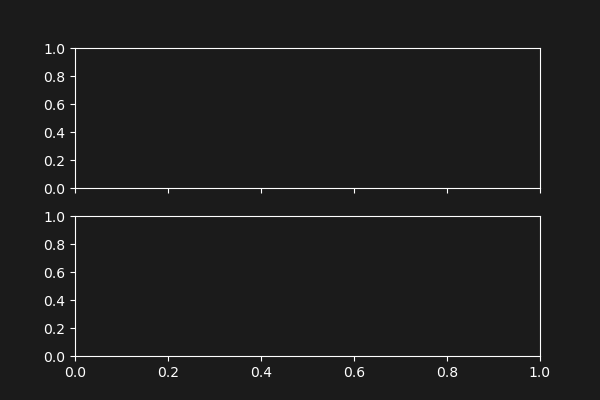

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│ /tmp/ipykernel_2766285/63916451.py:18 in <module>                                         │
│                                                                                           │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_2766285/63916451.py'                 │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
IndexError: index 5 is out of bounds for axis 0 with size 1

In [139]:
# colors=['#ff005c', '#eb6a7d', '#cd98a1', '#9dbfc6', '#00e2ed']
# colors=['#ff005ca0', '#eb6a7d', '#cd98a1', '#9dbfc6', '#00ff80ff', '#00e2ed0b']
colors=['#0000ffff', '#ff0000ff', '#ffaa000b']  # Colors for TTF 2022 poster
# saved_idx = [425, 911, 809, 255, 775]

scale_idx = 5
range_begin = 256 * scale_idx
range_end = 256 * (scale_idx+1)

data_sub_samps = data_samps[:, range_begin:range_end]
data_samps_mean = np.mean(data_sub_samps, axis=0)
data_samps_std = np.std(data_sub_samps, axis=0)

idx = np.random.randint(0, data_samps.shape[0])
fig, axes = plt.subplots(2,1, figsize=(6,4), sharex=True)

for i in range(data_sub_samps.shape[0]):
    axes[0].plot(xrange, data_sub_samps[i] * ptp[scale_idx] + mean[scale_idx], color=colors[-1], label="Sampled" if i==0 else None)

axes[0].plot(xrange, data_valid[data_valid_idx, range_begin:range_end] * ptp[scale_idx] + mean[scale_idx], color=colors[0], label="Real")
axes[0].plot(xrange, data_samps_mean * ptp[scale_idx] + mean[scale_idx], color=colors[-2], label="Sampled mean")

for i in range(data_sub_samps.shape[0]):
    axes[1].plot(xrange, (data_sub_samps[i] - data_samps_mean) * ptp[scale_idx] + mean[scale_idx], color=colors[-1])
axes[1].plot(xrange, (data_valid[data_valid_idx, range_begin:range_end] - data_samps_mean) * ptp[scale_idx] + mean[scale_idx], color=colors[0])
axes[1].plot(xrange, np.zeros(256), color=colors[-2])


axes[0].set_title('Diode 1 signal (Volts)')
axes[1].set_title('Real minus sampled')
axes[1].set_xlabel('Time(ms)')
axes[0].legend()
# axes[0].vlines(13.92,-1,10)
# axes[0].set_ylim(-0.6, 6)
# axes[1].vlines(13.92,-1,1)
# axes[1].set_ylim(-0.6, 0.6)
plt.tight_layout()
# plt.show()
# plt.savefig('reconstruction-ttf-2022.pdf')

## sample distribution about mean

<IPython.core.display.Javascript object>


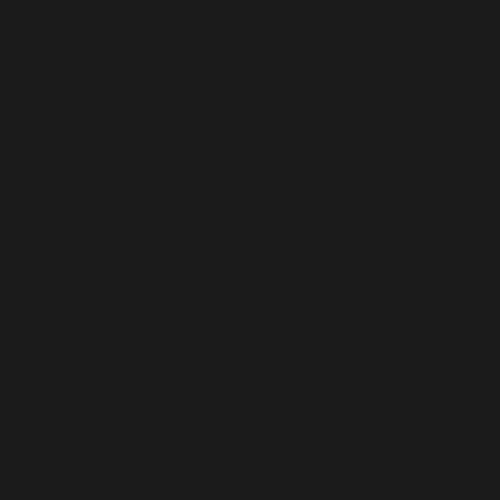

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│ /tmp/ipykernel_2971010/3229389845.py:2 in <module>                                        │
│                                                                                           │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_2971010/3229389845.py'               │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
IndexError: index 116 is out of bounds for axis 1 with size 0

In [118]:
plt.figure(figsize=(5, 5))
plt.hist(np.clip(data_samps[:, 256 * 4:256 * 5][:, 116],-100.81, 100.85) * ptp[4], bins=100, color=colors[-1]);
plt.title('Distribution of sampled diode signals at 13.92 ms')
plt.tight_layout()
# plt.savefig('sample-distribution-talk.pdf')
# 116 = 13.92 ms

# Unconditional sampling

## Energy histogram

color pallet webiste: #00d9ff, #ff005c

## Samples

## MSI histograms

# Real data

<IPython.core.display.Javascript object>


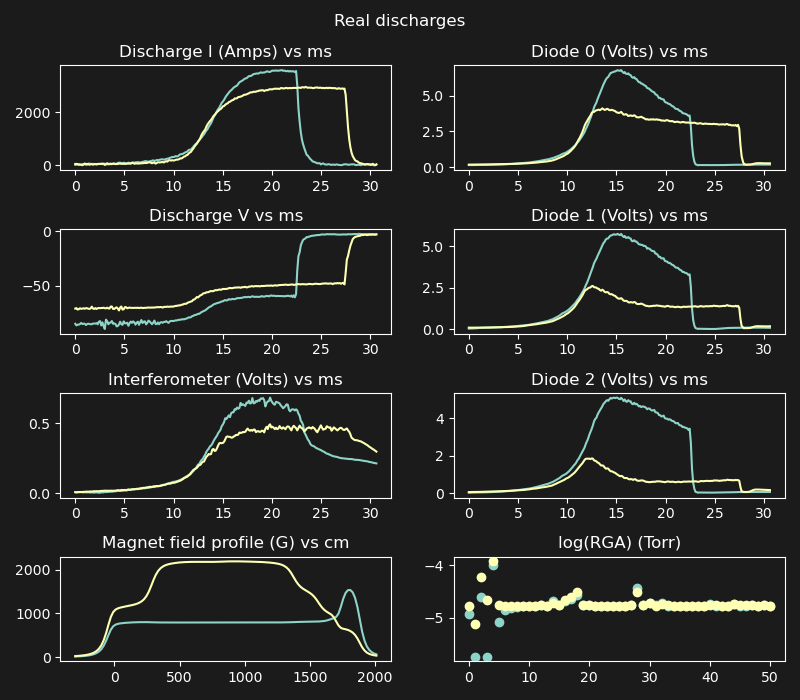

In [91]:
# idx = 10500  # for data_all
idx = 2100  # 2000 is missing both diode 0 and diode 1, starting at 2100: has both
fig, axes = plt.subplots(4,2, figsize=(8,7))
axes[0, 0].plot(xrange, data_valid[idx, 256 * 0:256 * 1] * ptp[0] + mean[0])
axes[1, 0].plot(xrange, data_valid[idx, 256 * 1:256 * 2] * ptp[1] + mean[1])
axes[2, 0].plot(xrange, data_valid[idx, 256 * 2:256 * 3] * ptp[2] + mean[2])
axes[0, 1].plot(xrange, data_valid[idx, 256 * 3:256 * 4] * ptp[3] + mean[3])
axes[1, 1].plot(xrange, data_valid[idx, 256 * 4:256 * 5] * ptp[4] + mean[4])
axes[2, 1].plot(xrange, data_valid[idx, 256 * 5:256 * 6] * ptp[5] + mean[5])
axes[3, 0].plot(B_xrange, data_valid[idx, 256 * 6:256 * 6 + 128] * ptp[6] + mean[6])
axes[3, 1].scatter(np.arange(51), data_valid[idx, -51:] * ptp[7] + mean[7])

# idx = 71235+82  # for data
idx = 22000  # 22000 for different magnetic field config
axes[0, 0].plot(xrange, data_valid[idx, 256 * 0:256 * 1] * ptp[0] + mean[0])
axes[1, 0].plot(xrange, data_valid[idx, 256 * 1:256 * 2] * ptp[1] + mean[1])
axes[2, 0].plot(xrange, data_valid[idx, 256 * 2:256 * 3] * ptp[2] + mean[2])
axes[0, 1].plot(xrange, data_valid[idx, 256 * 3:256 * 4] * ptp[3] + mean[3])
axes[1, 1].plot(xrange, data_valid[idx, 256 * 4:256 * 5] * ptp[4] + mean[4])
axes[2, 1].plot(xrange, data_valid[idx, 256 * 5:256 * 6] * ptp[5] + mean[5])
axes[3, 0].plot(B_xrange, data_valid[idx, 256 * 6:256 * 6 + 128] * ptp[6] + mean[6])
axes[3, 1].scatter(np.arange(51), data_valid[idx, -51:] * ptp[7] + mean[7])

axes[0, 0].set_title('Discharge I (Amps) vs ms')
axes[1, 0].set_title('Discharge V vs ms')
axes[2, 0].set_title('Interferometer (Volts) vs ms')
axes[0, 1].set_title('Diode 0 (Volts) vs ms')
axes[1, 1].set_title('Diode 1 (Volts) vs ms')
axes[2, 1].set_title('Diode 2 (Volts) vs ms')
axes[3, 0].set_title('Magnet field profile (G) vs cm')
axes[3, 1].set_title('log(RGA) (Torr)')
plt.suptitle("Real discharges")
plt.tight_layout()
# plt.savefig('real-discharges.pdf')

## X axis definitions

In [14]:
xrange = np.linspace(0, 1/(25000/3) * 255 * 1000, 256)
B_xrange = np.array([-300.      , -281.81583 , -263.63168 , -245.44751 , -227.26334 , -209.07918 , -190.89502 , -172.71085 , -154.52669 , -136.34251 , -118.158356,  -99.97419 ,  -81.79002 ,  -63.60586 ,  -45.421696, -27.237532,   -9.053368,    9.130797,   27.314962,   45.499126,  63.683292,   81.867455,  100.05162 ,  118.23579 ,  136.41995 , 154.60411 ,  172.78828 ,  190.97244 ,  209.1566  ,  227.34077 , 245.52493 ,  263.7091  ,  281.89328 ,  300.07742 ,  318.2616  , 336.44577 ,  354.6299  ,  372.8141  ,  390.99826 ,  409.1824  , 427.36658 ,  445.55075 ,  463.73492 ,  481.91907 ,  500.10324 , 518.2874  ,  536.47156 ,  554.65576 ,  572.8399  ,  591.02405 , 609.20825 ,  627.3924  ,  645.57654 ,  663.76074 ,  681.9449  , 700.129   ,  718.31323 ,  736.4974  ,  754.6815  ,  772.8657  , 791.04987 ,  809.234   ,  827.4182  ,  845.60236 ,  863.78656 , 881.9707  ,  900.15485 ,  918.33905 ,  936.5232  ,  954.70734 , 972.89154 ,  991.0757  , 1009.2598  , 1027.444   , 1045.6282  , 1063.8124  , 1081.9965  , 1100.1807  , 1118.3649  , 1136.549   , 1154.7332  , 1172.9174  , 1191.1014  , 1209.2856  , 1227.4698  , 1245.6539  , 1263.8381  , 1282.0223  , 1300.2064  , 1318.3906  , 1336.5748  , 1354.759   , 1372.9431  , 1391.1273  , 1409.3115  , 1427.4956  , 1445.6798  , 1463.864   , 1482.0481  , 1500.2323  , 1518.4165  , 1536.6006  , 1554.7848  , 1572.969   , 1591.1531  , 1609.3373  , 1627.5215  , 1645.7056  , 1663.8898  , 1682.074   , 1700.258   , 1718.4423  , 1736.6265  , 1754.8105  , 1772.9948  , 1791.179   , 1809.363   , 1827.5472  , 1845.7314  , 1863.9155  , 1882.0997  , 1900.2839  , 1918.468   , 1936.6522  , 1954.8364  , 1973.0205  , 1991.2047  , 2009.3889  ])